### CMIP6 data analysis with PCMCI
After running, PCA-Varimax and PCMCI, this notebook collects causal networks, calculate metrics, produce F1-score vs precipitation change plots, performance and independence plots, and stores the results to be later used by the weighting recipe

In [1]:
import glob
from matplotlib import pyplot as plt
%matplotlib inline
import pickle
import numpy as np
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
import pandas as pd
import scienceplots
plt.style.use(['science','nature'])

In [2]:
save_res= True
make_dic= True
plot_figure = True
time_bin=1
tau_max=10

Define paths to CMIP5 or CMIP6 data folders depending on use_CMIP6_data boolean value for the rest of the notebook

In [3]:
import yaml

# Load YAML config
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

#define all paths to CMIP6 data folders
#all psl paths
psl_1979_2014_path= config["detrend_data_path"]
pca_res_path=config["weight_path"]
pcmci_res_path=config["pcmci_results_era5"]
#pr paths
pr_histo_path = config["pr_histo_path"]
pr_scenario_path = config["pr_ssp_path"]
pr_1979_2014_path= config["pr_histo_path"]
#csv/bin output files
global_res_path = "./global_link_and_parents_1979-2014_era5_weights_psl_timebin1x2_60selectedcomps_taumax20.bin"
delta_precip_file="./delta_precip_histo_1860-1910_vs_%s_2050-2100_final_version.csv"
sscore_file="./seasonnal_S_score_model_versus_%s.csv"
   

In [5]:
#Load PCMCI results
save_global_res= True
selected_comps_indices=[i for i in range(0,60)]
var_names=["X_"+str(i) for i in range(0,60)]
alpha_list = [0.001,0.0001,0.00001] #[0.01,0.001,0.0001,0.00001]
if make_dic:
    link_mat_alpha_dic = {}
    link_mat_dic= {}
    val_mat_dic={}
    val_mat_alpha_dic={}
    p_mat_dic={}
    p_mat_alpha_dic={}
    q_mat_dic={}
    q_mat_alpha_dic={}
    ak_dic={}
    ak_alpha_dic={}
    for alpha_level in alpha_list:
        for res_file in glob.glob(pcmci_res_path+"/results_*.bin"):

            res = pickle.load(open(res_file,"rb"))
            results= res["results"]
            file_name = res['file_name']
            info_model= file_name.split("_")
            dataset_name = info_model[2]
            ensemble=""
            if dataset_name != "ERA5":
                dataset_name= info_model[2]
                if use_CMIP6_data:
                    ensemble= info_model[5]
                else : ensemble= info_model[7]
            if dataset_name == "GISS-E2-R":
                ensemble= info_model[5]
            season= info_model[-1][7:-4]

            print("Current model, ensemble, season : "+dataset_name+" "+ensemble+" "+season )
            file_path = pca_res_path+"/"+ file_name
            datadict = pickle.load(open(file_path, 'rb'))
            d = datadict['results']
            time_mask = d['time_mask']
            fulldata = d['ts_unmasked']
            N = 60
            fulldata_mask = np.repeat(time_mask.reshape(len(d['time']), 1), N, axis=1)
            fulldata = fulldata[:, 0:N]
            fulldata_mask = fulldata_mask[:, 0:N]
            dataframe = pp.DataFrame(fulldata, mask=fulldata_mask)
            
            CI_params = {       'significance':'analytic', 
                                'mask_type':['y'],
                                'recycle_residuals':False,
                                }
            cond_ind_test = ParCorr(**CI_params)
            pcmci=PCMCI(cond_ind_test=cond_ind_test,dataframe=dataframe)
            val_mat_dic.setdefault(season,{})
            val_mat_dic[season].setdefault(dataset_name,{})
            val_mat_dic[season][dataset_name].setdefault(ensemble,None)
            val_mat_dic[season][dataset_name][ensemble]= results['val_matrix']
            p_mat_dic.setdefault(season,{})
            p_mat_dic[season].setdefault(dataset_name,{})
            p_mat_dic[season][dataset_name].setdefault(ensemble,)
            p_mat_dic[season][dataset_name][ensemble]= results['p_matrix']

        p_mat_alpha_dic[alpha_level]= p_mat_dic
        val_mat_alpha_dic[alpha_level]= val_mat_dic

    global_res = {"p_val":p_mat_alpha_dic,"val_mat":val_mat_alpha_dic}

    if save_global_res :
        print("Writing global results file: "+global_res_path)
        with open(global_res_path, 'wb') as file:
            pickle.dump(global_res, file)

else:
    with open(global_res_path, 'rb') as file:
        global_res = pickle.load(file)

In [6]:
# F1-score to compare networks
def get_metric_f1(ref_p_matrix, p_matrix, ref_val_matrix, val_matrix, alpha, 
            tau_min=0, tau_diff=1, same_sign=True):

    N, N, taumaxp1 = val_matrix.shape
    TP = 0
    FP = 0
    FN = 0
    auto = 0
    count = 0
    for i in range(N):
        for j in range(N):
            if i != j:
                for tau in range(tau_min, taumaxp1):
                    if ref_p_matrix[i,j,tau] > alpha and p_matrix[i,j,tau] < alpha:
                        FP += 1
                    elif ref_p_matrix[i,j,tau] < alpha and np.any(p_matrix[i,j,max(0,tau-tau_diff):tau+tau_diff+1] < alpha):
                        count +=1
                        if same_sign==True and np.sign(ref_val_matrix[i,j,tau]) == np.sign(val_matrix[i,j,tau]):
                            TP += 1
                        elif same_sign==True and np.sign(ref_val_matrix[i,j,tau]) != np.sign(val_matrix[i,j,tau]):
                            FN += 1
                        elif same_sign==False:
                            TP += 1
                    elif ref_p_matrix[i,j,tau] < alpha and not(np.any(p_matrix[i,j,max(0,tau-tau_diff):tau+tau_diff+1] < alpha)):
                        FN += 1
            else:
                auto +=1
    precision =  float(TP+1e-10) / float(TP + FP +1e-10)
    recall = float(TP+1e-10) / float(TP + FN +1e-10)
    f1 = 2.0*precision*recall/float(precision + recall)
    return precision, recall, TP, FP, FN, f1, auto, count

Create a panda DataFrame containing all F1-score against reference network for all seasons for all available model,ensembles

In [7]:
####This cell creates df_f1score pandasframe which stores WDM for all season,model,ensemble triplets
alpha = 0.00001
ref_ds="ERA5"
p_mat_dic=global_res["p_val"][alpha]
val_mat_dic= global_res["val_mat"][alpha]
#ak_mat_dic = global_res["AK_matrix"][alpha]
score_list =[]
for season in p_mat_dic:
    if season !="global":#drop global
        for dataset in p_mat_dic[season]:
            for ensemble in p_mat_dic[season][dataset]:
                if dataset!=ref_ds:
                    ref_p_matrix= p_mat_dic[season][ref_ds][""]
                    p_matrix= p_mat_dic[season][dataset][ensemble]
                    ref_val_matrix= val_mat_dic[season][ref_ds][""]
                    val_matrix= val_mat_dic[season][dataset][ensemble]
                    precision, recall, TP, FP, FN, score, auto, count = get_metric_f1(ref_p_matrix[:60,:60,:], p_matrix[:60,:60,:], ref_val_matrix[:60,:60,:], val_matrix[:60,:60,:],
                    alpha, tau_min=1, tau_diff=2, same_sign=True) #tau_diff=3
                    score_list.append([season,dataset,ensemble,score])

season,dataset,ensemble,score= [list(a) for a in zip(*score_list)]
df_f1score_global = pd.DataFrame({"season":season,"model":dataset,"ensemble":ensemble,"F1-score":score})
df_f1score_seasonaveraged_global = df_f1score_global.groupby(["model","ensemble"])["F1-score"].mean().rename("F1-score",inplace=True).to_frame()
df_f1score_seasonaveraged_global

F1-score
model         ensemble          
ACCESS-CM2    r1i1p1f1  0.690611
              r2i1p1f1  0.686507
              r3i1p1f1  0.693884
ACCESS-ESM1-5 r1i1p1f1  0.663627
              r2i1p1f1  0.656960
...                          ...
UKESM1-0-LL   r5i1p1f3  0.693278
              r6i1p1f3  0.699181
              r7i1p1f3  0.693419
              r8i1p1f2  0.696882
              r9i1p1f2  0.693293

[169 rows x 1 columns]

In [8]:
to_keep = ["FGOALS-g3_r1i1p1f1","FGOALS-g3_r3i1p1f1","KACE-1-0-G_r3i1p1f1","MIROC-ES2L_r10i1p1f2","MIROC-ES2L_r1i1p1f2",
"MIROC-ES2L_r2i1p1f2","MIROC-ES2L_r3i1p1f2","MIROC-ES2L_r4i1p1f2","MIROC-ES2L_r5i1p1f2","MIROC-ES2L_r6i1p1f2",
"MIROC-ES2L_r7i1p1f2","MIROC-ES2L_r8i1p1f2","MIROC-ES2L_r9i1p1f2","MIROC6_r10i1p1f1","MIROC6_r1i1p1f1","MIROC6_r2i1p1f1",
"MIROC6_r3i1p1f1","MIROC6_r4i1p1f1","MIROC6_r5i1p1f1","MIROC6_r6i1p1f1","MIROC6_r7i1p1f1","MIROC6_r8i1p1f1","MIROC6_r9i1p1f1",
"MPI-ESM1-2-HR_r1i1p1f1","MPI-ESM1-2-HR_r2i1p1f1","MPI-ESM1-2-LR_r10i1p1f1","MPI-ESM1-2-LR_r1i1p1f1","MPI-ESM1-2-LR_r2i1p1f1",
"MPI-ESM1-2-LR_r3i1p1f1","MPI-ESM1-2-LR_r4i1p1f1","MPI-ESM1-2-LR_r5i1p1f1","MPI-ESM1-2-LR_r6i1p1f1","MPI-ESM1-2-LR_r7i1p1f1",
"MPI-ESM1-2-LR_r8i1p1f1","MPI-ESM1-2-LR_r9i1p1f1","MRI-ESM2-0_r1i1p1f1","MRI-ESM2-0_r1i2p1f1","MRI-ESM2-0_r2i1p1f1",
"MRI-ESM2-0_r3i1p1f1","MRI-ESM2-0_r4i1p1f1","MRI-ESM2-0_r5i1p1f1","NorESM2-LM_r1i1p1f1","UKESM1-0-LL_r1i1p1f2","UKESM1-0-LL_r2i1p1f2",
"UKESM1-0-LL_r3i1p1f2","UKESM1-0-LL_r4i1p1f2","KACE-1-0-G_r2i1p1f1","KACE-1-0-G_r1i1p1f1","ACCESS-CM2_r1i1p1f1","ACCESS-CM2_r2i1p1f1",
"ACCESS-CM2_r3i1p1f1","ACCESS-ESM1-5_r1i1p1f1","ACCESS-ESM1-5_r2i1p1f1","ACCESS-ESM1-5_r3i1p1f1","BCC-CSM2-MR_r1i1p1f1",
"CESM2_r1i1p1f1","CESM2-WACCM_r1i1p1f1","CESM2-WACCM_r2i1p1f1","CESM2-WACCM_r3i1p1f1","CNRM-CM6-1_r1i1p1f2","CNRM-CM6-1_r2i1p1f2",
"CNRM-CM6-1_r3i1p1f2","CNRM-CM6-1_r4i1p1f2","CNRM-CM6-1_r5i1p1f2","CNRM-CM6-1_r6i1p1f2","CNRM-ESM2-1_r1i1p1f2",
"CNRM-ESM2-1_r2i1p1f2","CNRM-ESM2-1_r3i1p1f2","CNRM-ESM2-1_r4i1p1f2","CNRM-ESM2-1_r5i1p1f2","CanESM5_r10i1p1f1",
"CanESM5_r1i1p1f1","CanESM5_r1i1p2f1","CanESM5_r2i1p1f1","CanESM5_r2i1p2f1","CanESM5_r3i1p1f1",
"CanESM5_r3i1p2f1","CanESM5_r4i1p1f1","CanESM5_r4i1p2f1","CanESM5_r5i1p1f1","CanESM5_r6i1p1f1",
"CanESM5_r7i1p1f1","CanESM5_r8i1p1f1","CanESM5_r9i1p1f1","EC-Earth3_r11i1p1f1",
"EC-Earth3_r1i1p1f1","EC-Earth3_r4i1p1f1","EC-Earth3-Veg_r1i1p1f1","EC-Earth3-Veg_r2i1p1f1",
"EC-Earth3-Veg_r3i1p1f1","EC-Earth3-Veg_r4i1p1f1","HadGEM3-GC31-LL_r1i1p1f3","HadGEM3-GC31-LL_r2i1p1f3",
"HadGEM3-GC31-LL_r3i1p1f3","HadGEM3-GC31-LL_r4i1p1f3","HadGEM3-GC31-MM_r1i1p1f3",
"HadGEM3-GC31-MM_r2i1p1f3","HadGEM3-GC31-MM_r3i1p1f3","HadGEM3-GC31-MM_r4i1p1f3",
"INM-CM5-0_r1i1p1f1","IPSL-CM6A-LR_r1i1p1f1","IPSL-CM6A-LR_r2i1p1f1","IPSL-CM6A-LR_r3i1p1f1","IPSL-CM6A-LR_r4i1p1f1","IPSL-CM6A-LR_r6i1p1f1"]
model_to_keep = list(set([model_ensemble.split("_")[0] for model_ensemble in to_keep]))

In [22]:
df_f1score_seasonaveraged_global = df_f1score_seasonaveraged_global.loc[df_f1score_seasonaveraged_global.index.get_level_values('model').isin(model_to_keep)]

### F1-score vs DeltaPrecip over land

In [23]:
pr_ssp585_2050_2099_regridtoNCEP= pr_scenario_path + "/ssp585_2050-2099_regridtoNCEP_extract_region_mean/"
pr_ssp370_2050_2099_regridtoNCEP= pr_scenario_path+ "/ssp370_2050-2099_regridtoNCEP_extract_region_mean/"
pr_ssp245_2050_2099_regridtoNCEP= pr_scenario_path + "/ssp245_2050-2099_regridtoNCEP_extract_region_mean/"
pr_histo_1860_1910_regridtoNCEP= pr_histo_path+ "histo_1860-1910_regridtoNCEP_extract_region_mean/"
deltaPrecip_result_template="./regional_deltaPrecip_%s_scenario_regridtoNCEP.csv"
mask_list = ["North-America","South-America","Europe","Africa","South-Asia","East-Asia","Oceania"]

### Calculate deltaPrecip

In [24]:
import pandas as pd
import numpy as np
import os
import glob
import pickle
import warnings
warnings.simplefilter("ignore")
import copy

def compute_mean_diff(histo_cube,ssp_cube):
    spatial_diff= ssp_cube - histo_cube
    #compute area weighted mean
    try :
        area_weighted_mean = float(spatial_diff.collapsed(["latitude","longitude"],iris.analysis.MEAN,weights=iris.analysis.cartography.area_weights(spatial_diff)).data)
    except ValueError:
        lat= spatial_diff.coord("latitude")
        lon= spatial_diff.coord("longitude")
        lon.guess_bounds()
        lat.guess_bounds()
        area_weighted_mean = float(spatial_diff.collapsed(["latitude","longitude"],iris.analysis.MEAN,weights=iris.analysis.cartography.area_weights(spatial_diff)).data)
    return area_weighted_mean

def get_delta_precip(pr_histo_1860_1910_path, pr_scenario_path, scenario_name,make_dic,save_res,result_file_name,mask_list):
#Compute Precipitation difference on climatology between two periods for all model datasets.
#Saved in a dictionnary
    if make_dic:

        res_list=[]
        model_list=[]
        ensemble_list=[]
        region_list= []
        for region in mask_list:
            source_path_scenario = pr_scenario_path+"/"+region+"/"
            source_path_histo = pr_histo_1860_1910_path+"/"+region+"/"

            print(source_path_scenario+"/CMIP*.nc")
            for file_ in glob.glob(source_path_scenario+"/CMIP*.nc"):
                print(file_)
                try:
                    rcp85_file_name= os.path.basename(file_)
                    model_name= os.path.basename(rcp85_file_name).split("_")[1]
                    ensemble= os.path.basename(rcp85_file_name).split("_")[4]
                    if scenario_name =="rcp85":
                        histo_file_name= source_path_histo+rcp85_file_name.replace("2050","1860").replace("2099","1910").replace(scenario_name,"historical")
                    else:
                        histo_file_name= source_path_histo+rcp85_file_name.replace("2050","1860").replace("2099","1910").replace(scenario_name,"historical")
                    print("Computing Delta Precipitation between "+ scenario_name+" 2050-2100 and  1860-1910 for "+model_name+" "+ensemble)
                    #LOAD CUBE
                    rcp85_cube = iris.load_cube(file_,"precipitation_flux")
                    histo_cube = iris.load_cube(histo_file_name,"precipitation_flux")

                    #COMPUTE DIFF
                    diff_ = compute_mean_diff(histo_cube,rcp85_cube)
                    model_list.append(model_name)
                    ensemble_list.append(ensemble)
                    region_list.append(region)
                    res_list.append(diff_)
                    del histo_cube
                    del rcp85_cube
                except Exception as e:
                    print(e)
                    pass

        model,ensemble,region_list,res_list= (list(t) for t in zip(*sorted(zip(model_list,ensemble_list,region_list,res_list))))
        df_deltaPrecip= pd.DataFrame({"model":model,"ensemble":ensemble,"region":region_list,"deltaPrecip":res_list})
        if save_res:
            print("Now saving results in CSV format")
            df_deltaPrecip.to_csv(result_file_name)
    else:
        print("Loading file")
        df_deltaPrecip= pd.read_csv(result_file_name)
        df_deltaPrecip.drop("Unnamed: 0",axis=1,inplace=True)


    #Convert unit from kg/m2/s to mm/day
    df_deltaPrecip.loc[:,"deltaPrecip"]*=86400
    print(df_deltaPrecip.to_string())
    return(df_deltaPrecip)

In [ ]:
scenario_name = "ssp585"
df_deltaPrecip_ssp585 = get_delta_precip(pr_histo_1860_1910_regridtoNCEP, pr_ssp585_2050_2099_regridtoNCEP, scenario_name,
                 make_dic,save_res,deltaPrecip_result_template%scenario_name,mask_list)
scenario_name = "ssp370"
df_deltaPrecip_ssp370 = get_delta_precip(pr_histo_1860_1910_regridtoNCEP, pr_ssp370_2050_2099_regridtoNCEP, scenario_name,
                 make_dic,save_res,deltaPrecip_result_template%scenario_name,mask_list)
scenario_name = "ssp245"
df_deltaPrecip_ssp245 = get_delta_precip(pr_histo_1860_1910_regridtoNCEP, pr_ssp245_2050_2099_regridtoNCEP, scenario_name,
                 make_dic,save_res,deltaPrecip_result_template%scenario_name,mask_list)

In [ ]:
import numpy as np
import pylab
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel as WK,\
ExpSineSquared as ESS, RationalQuadratic as RQ, Matern as M
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import scipy.stats as stats
# Function to show the summary of the fit
def summary(gp):
    optimized = gp.optimizer != None
    if not optimized:
        s1 = "Fitted Kernel(not optimized)\n%s" % gp.kernel_
    else:
        s1 = "Fitted Kernel(Optimized)\n%s" % gp.kernel_
    s2 = "\nlog marginal likelihood: %.5f" % gp.log_marginal_likelihood(gp.kernel_.theta)
    return (s1 + s2)

def gaussian_process_fit(x, y,plot_title):
    
    # Specify observations
    n_obs = len(x)
    X_obs = x.reshape(n_obs, 1)
    x_min = x.min() - .1*(x.max()-x.min())
    x_max = x.max() + .1*(x.max()-x.min())
    f_obs = y
    
    #KERNEL used
    kernel = 10 * RBF(1, (1e-3, 1e3)) + WK(1)
    gp = GPR(kernel=kernel, alpha = 0.00000001, n_restarts_optimizer=20)
    gp.fit(X_obs, f_obs)
    print(summary(gp))

    # Make a prediction on test points
    X_test = np.array(np.linspace(x_min, x_max, 1000), ndmin = 2).T
    f_mean, f_var = gp.predict(X_test, return_std=True)

    # Create a Plot
    fig_noisy = plt.figure(figsize = (5,4))
    plt.rcParams.update({'font.size': 12})

    # Mark the observations
    plt.plot(X_obs, f_obs, 'ro', label='CMIP6 models')

    # Draw a mean function and 95% confidence interval
    plt.plot(X_test, f_mean, 'b-', label='mean function')
    upper_bound = f_mean + 1.96 * f_var
    lower_bound = f_mean - 1.96 * f_var
    plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'b', alpha = 0.2,
                     label='95% confidence interval')
    # Aesthetics
    plt.xlabel('$\Delta$ Precipitation over land (mm/day)',size=24)
    plt.ylabel('Regional F1-score',size=24)
    plt.xlim(x_min, x_max)
    plt.title(plot_title)
    plt.legend(loc='lower left')
    plt.show()

def poly_fit_test(x, y, nickname, pvalue, title):
    plt.rcParams['figure.figsize'] = (5, 4)
    degree = 2

    df = pd.DataFrame(columns=['y', 'x'])
    df['x'] = x
    df['y'] = y

    weights = np.polyfit(x, y, degree)
    model = np.poly1d(weights)

    # Fit the model using statsmodels
    results = smf.ols(formula='y ~ model(x)', data=df).fit()
    p_val_poly = results.pvalues[1]

    # Goodness-of-fit metrics
    r_squared = 1 - results.ssr/results.centered_tss
    print(f"R^2: {r_squared:.3f}")

    # Confidence Interval Setup
    x_min = x.min() - .3 * (x.max() - x.min())
    x_max = x.max() + .3 * (x.max() - x.min())
    X_test = np.linspace(x_min, x_max, 1000)
    f_mean = model(X_test)

    # Fit Polynomial Features
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(x.reshape(-1, 1))  # Training data
    X_poly_test = poly.transform(X_test.reshape(-1, 1))  # Test points
    # Calculate influence term using training data
    XTX_inv = np.linalg.inv(X_poly_train.T @ X_poly_train)  # Inverse of X^T X
    influence = np.sum(X_poly_test @ XTX_inv * X_poly_test, axis=1)  # Influence term

    # Standard error of prediction
    pred_std = np.sqrt(results.mse_resid * (1 + influence))
    t_crit = stats.t.ppf(0.95, df=len(x) - degree - 1)  # 90% CI
    ci_upper = f_mean + t_crit * pred_std
    ci_lower = f_mean - t_crit * pred_std

    # Visualization
    fig = plt.figure(figsize=(5, 4))
    params = {'legend.fontsize': 'small',
              'axes.labelsize': 'large',
              'axes.titlesize': 'x-large',
              'xtick.labelsize': 'large',
              'ytick.labelsize': 'large'}
    pylab.rcParams.update(params)
    plt.plot(x, y, 'ko', label='CMIP6 models')
    plt.fill_between(X_test, ci_lower, ci_upper, color='red', alpha=0.2, label='90$\%$ Confidence band')
    plt.plot(X_test, f_mean, 'r-', label=r'y = a+b$\cdot$x+c$\cdot$x$^2$')

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    reg_line = intercept + slope * np.arange(x_min, x_max, 0.02)
    plt.plot(np.arange(x_min, x_max, 0.02), reg_line, color='b', linewidth=1, linestyle='--', label=r'y = a+b$\cdot$x')

    plt.title(r'$F_1$ scores ' + title)
    plt.figtext(0.15, 0.825, 'p (poly) = ' + str(round(p_val_poly, 5)), color='red')
    plt.figtext(0.15, 0.775, 'p (lin) = ' + str(round(p_value, 3)), color='blue')
    # plt.figtext(0.15, 0.725, r'$R^2$ = ' + str(round(r_squared, 3)), color='green')
    plt.xlabel('$\Delta$ Precipitation over land (mm.day$^{-1}$)')
    plt.ylabel(r'$F_1$ score against ERA5')
    plt.xlim(x_min, x_max)
    plt.legend(loc='lower left')

    SSP = str(title.split(" ")[3])
    
    # Add figure label to the top-left corner
    figure_label = {'SSP5-8.5': '(d)', 'SSP3-7.0': '(e)', 'SSP2-4.5': '(f)'}.get(SSP, '')
    plt.text(-0.15, 1.12, figure_label, transform=plt.gca().transAxes,
             fontsize=25, fontweight='bold', va='top', ha='left')
    
    savefile = 'precip_vs_F1_polyfit_60comp_' + SSP + '_ERA5.pdf'
    print(savefile)
    plt.savefig(savefile, dpi=300)
    plt.show()


# Global results

Fitted Kernel(Optimized)
0.673**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=0.000277)
log marginal likelihood: 53.64470


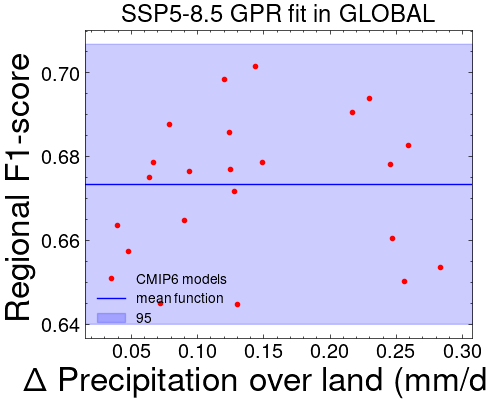

R^2: 0.214
(1000,)
precip_vs_F1_polyfit_60comp_SSP5-8.5_ERA5.pdf


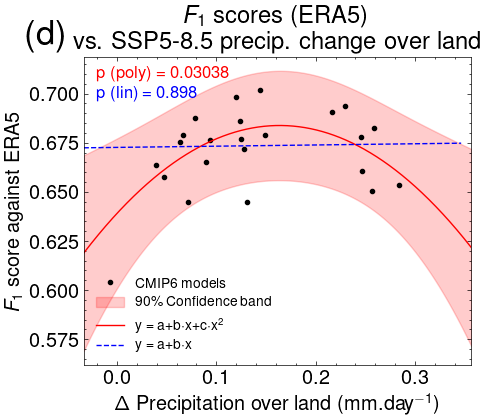

In [79]:
df_deltaPrecip_f1score = pd.merge(df_deltaPrecip_ssp585[df_deltaPrecip_ssp585["region"]=="Global"],df_f1score_seasonaveraged_global,on=['model','ensemble'])
df_temp = df_deltaPrecip_f1score
deltaPrecip_series_ssp585 = df_temp["deltaPrecip"].to_numpy()
f1_series_ssp585 = df_temp["F1-score"].to_numpy()
gaussian_process_fit(deltaPrecip_series_ssp585,f1_series_ssp585,"SSP5-8.5 GPR fit in GLOBAL")
poly_fit_test(deltaPrecip_series_ssp585,f1_series_ssp585,"",0.01,"(ERA5) \n vs. SSP5-8.5 precip. change over land")

Fitted Kernel(Optimized)
0.676**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=0.00017)
log marginal likelihood: 44.26896


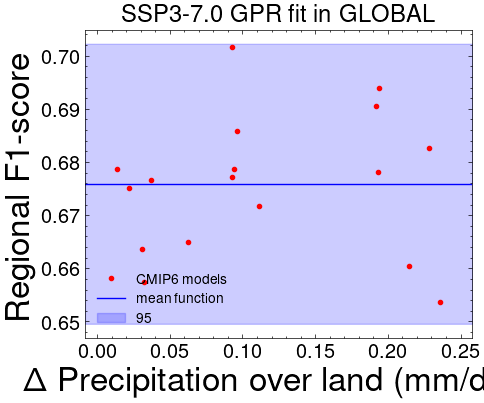

R^2: 0.217
(1000,)
precip_vs_F1_polyfit_60comp_SSP3-7.0_ERA5.pdf


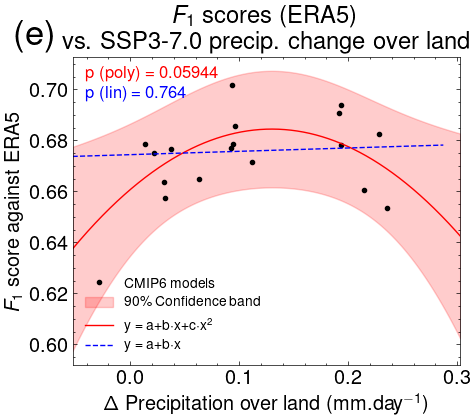

In [80]:
df_deltaPrecip_f1score = pd.merge(df_deltaPrecip_ssp370[df_deltaPrecip_ssp370["region"]=="Global"],df_f1score_seasonaveraged_global,on=['model','ensemble'])
df_temp = df_deltaPrecip_f1score
deltaPrecip_series_ssp370 = df_temp["deltaPrecip"].to_numpy()
f1_series_ssp370 = df_temp["F1-score"].to_numpy()
gaussian_process_fit(deltaPrecip_series_ssp370,f1_series_ssp370,"SSP3-7.0 GPR fit in GLOBAL")
poly_fit_test(deltaPrecip_series_ssp370,f1_series_ssp370,"",0.01,"(ERA5) \n vs. SSP3-7.0 precip. change over land")

Fitted Kernel(Optimized)
0.673**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=0.000286)
log marginal likelihood: 50.65918


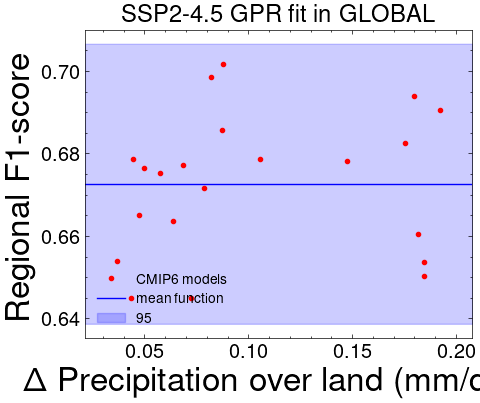

R^2: 0.198
(1000,)
precip_vs_F1_polyfit_60comp_SSP2-4.5_ERA5.pdf


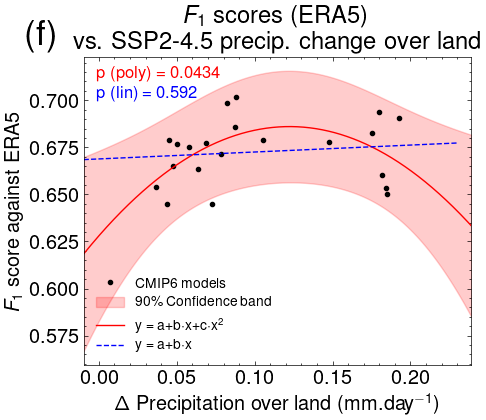

In [81]:
df_deltaPrecip_f1score = pd.merge(df_deltaPrecip_ssp245[df_deltaPrecip_ssp245["region"]=="Global"],df_f1score_seasonaveraged_global,on=['model','ensemble'])
df_temp = df_deltaPrecip_f1score
deltaPrecip_series_ssp245 = df_temp["deltaPrecip"].to_numpy()
f1_series_ssp245 = df_temp["F1-score"].to_numpy()
gaussian_process_fit(deltaPrecip_series_ssp245,f1_series_ssp245,"SSP2-4.5 GPR fit in GLOBAL")
poly_fit_test(deltaPrecip_series_ssp245,f1_series_ssp245,"",0.01,"(ERA5) \n vs. SSP2-4.5 precip. change over land")

### Calculate interdependence

In [4]:
make_dic=True
global_f1_path = "./global_f1_independence_era5_1979-2014_weights_alpha_%s_%s_selected_60comps.bin"

In [5]:
####This cell creates df_f1score pandasframe which stores F1-score for all season,model,ensemble triplets
alpha = 0.00001
timebin = "timebin1x2"
global_f1_path=global_f1_path%(str(alpha),timebin)
if make_dic:
    df_f1score= {}
    p_mat_dic=global_res["p_val"][alpha]
    val_mat_dic= global_res["val_mat"][alpha]
    score_list =[]
    for season in val_mat_dic:
        if season !="global":#drop global
            for dataset in val_mat_dic[season]:
                for ensemble in val_mat_dic[season][dataset]:
                    for dataset2 in val_mat_dic[season]:
                        for ensemble2 in val_mat_dic[season][dataset2]:
                            if not (dataset2== dataset and ensemble2 == ensemble):
                                ref_p_matrix= p_mat_dic[season][dataset2][ensemble2]
                                p_matrix= p_mat_dic[season][dataset][ensemble]
                                ref_val_matrix= val_mat_dic[season][dataset2][ensemble2]
                                val_matrix= val_mat_dic[season][dataset][ensemble]
                                precision, recall, TP, FP, FN, score, auto, count = get_metric_f1(ref_p_matrix[:60,:60,:], p_matrix[:60,:60,:], ref_val_matrix[:60,:60,:], val_matrix[:60,:60,:], alpha, 
                                tau_min=1, tau_diff=2, same_sign=True)
                                score_list.append([season,dataset,ensemble,dataset2,ensemble2,score])
    season,dataset,ensemble,dataset2,ensemble2,score= [list(a) for a in zip(*score_list)]
    df_f1score_ = pd.DataFrame({"season":season,"model":dataset,"ensemble":ensemble,"ref_model":dataset2,"ref_ensemble":ensemble2,"F1-score":score})
    #get average F1-score over seasons
    pickle.dump(df_f1score_,open(global_f1_path,"wb"))
    df_f1score = df_f1score_
else:
    df_f1score = pickle.load(open(global_f1_path,"rb"))

In [20]:
import copy
import seaborn as sn
import matplotlib
import pylab
df_heatmap = df_f1score
df_heatmap["model_ensemble_reference"] = df_heatmap[["ref_model","ref_ensemble"]].astype(str).apply('_'.join, axis=1)
df_heatmap["model_ensemble"] = df_heatmap[["model","ensemble"]].astype(str).apply('_'.join, axis=1)
df_heatmap = df_heatmap[df_heatmap["model_ensemble_reference"].isin(to_keep)]
df_heatmap = df_heatmap[df_heatmap["model_ensemble"].isin(to_keep)]
df_heatmap = df_heatmap.groupby(["model","ref_model"],as_index=False)["F1-score"].mean()
df_heatmap_n= df_heatmap.pivot(index="model",columns="ref_model")["F1-score"]
df_heatmap_r= df_heatmap.pivot(columns="model",index="ref_model")["F1-score"]
np.fill_diagonal(df_heatmap_n.values, np.nan)
np.fill_diagonal(df_heatmap_r.values, np.nan)
df_heatmap_sym = (df_heatmap_n+df_heatmap_r)/2.

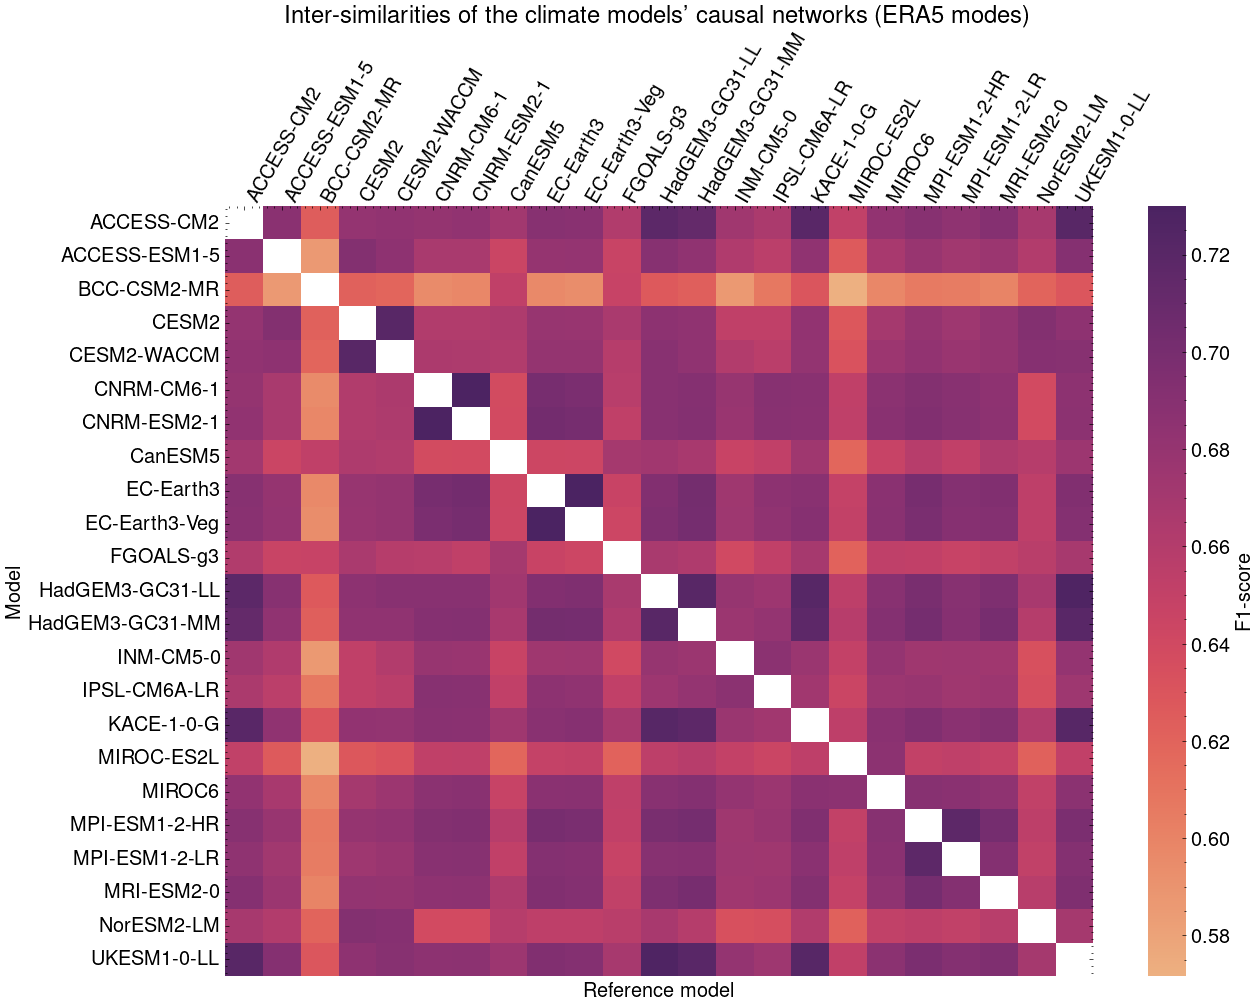

In [21]:
cmap = sn.color_palette("flare", as_cmap=True)
fig = plt.figure(figsize=(14,10))
params = {'legend.fontsize': 'small',
        #'figure.figsize': (15, 5),
        'axes.labelsize': 'large',
        'axes.titlesize':'x-large',
        'xtick.labelsize':'large',
        'ytick.labelsize':'large'}
pylab.rcParams.update(params)
g = sn.heatmap(df_heatmap_sym, cmap=cmap,annot=False)
g.xaxis.set_ticks_position("top")
g.collections[0].colorbar.set_label("F1-score")
g.set_title('Inter-similarities of the climate models\' causal networks (ERA5 modes)',weight="bold")
g.set_xlabel('Reference model',weight="bold")
g.set_ylabel('Model',weight="bold")
g.set_xticklabels(g.get_xticklabels(), rotation=60,verticalalignment= 'baseline',horizontalalignment= "left")
plt.savefig('interdependence_heatmap_60comps_ERA5.pdf',dpi=300)
plt.show()


In [22]:
import copy
df_f1score_selected_models = df_f1score
df_f1score_selected_models["model_ensemble_reference"] = df_f1score_selected_models[["ref_model","ref_ensemble"]].astype(str).apply('_'.join, axis=1)
df_f1score_selected_models["model_ensemble"] = df_f1score_selected_models[["model","ensemble"]].astype(str).apply('_'.join, axis=1)
df_f1score_selected_models = df_f1score_selected_models[df_f1score_selected_models["model_ensemble_reference"].isin(to_keep)]
df_f1score_selected_models = df_f1score_selected_models[df_f1score_selected_models["model_ensemble"].isin(to_keep)]
df_f1score_selected_models = df_f1score_selected_models.drop(columns=["ref_model","ref_ensemble","model","ensemble"])
df_f1score_selected_models= df_f1score_selected_models.groupby(["model_ensemble","model_ensemble_reference"],as_index=False)["F1-score"].mean()
df_ssp370 = copy.copy(df_f1score_selected_models)
df_ssp245 = copy.copy(df_f1score_selected_models)
df_f1score_selected_models["model_ensemble"] = df_f1score_selected_models["model_ensemble"]+"_historical-ssp585"
df_f1score_selected_models["model_ensemble_reference"] = df_f1score_selected_models["model_ensemble_reference"]+"_historical-ssp585"
df_ssp370["model_ensemble"] = df_ssp370["model_ensemble"]+"_historical-ssp370"
df_ssp370["model_ensemble_reference"] = df_ssp370["model_ensemble_reference"]+"_historical-ssp370"
df_ssp245["model_ensemble"] = df_ssp245["model_ensemble"]+"_historical-ssp245"
df_ssp245["model_ensemble_reference"] = df_ssp245["model_ensemble_reference"]+"_historical-ssp245"


In [24]:
new_xr_ind = df_f1score_selected_models.rename(columns = {'F1-score':'dcme'}, inplace = False).set_index(['model_ensemble', 'model_ensemble_reference']).to_xarray()
new_xr_ind_ssp370 = df_ssp370.rename(columns = {'F1-score':'dcme'}, inplace = False).set_index(['model_ensemble', 'model_ensemble_reference']).to_xarray()
new_xr_ind_ssp245 = df_ssp245.rename(columns = {'F1-score':'dcme'}, inplace = False).set_index(['model_ensemble', 'model_ensemble_reference']).to_xarray()

In [25]:
new_xr_ind=new_xr_ind.dcme
new_xr_ind_ssp370=new_xr_ind_ssp370.dcme
new_xr_ind_ssp245=new_xr_ind_ssp245.dcme

In [26]:
new_xr_ind= 1 - new_xr_ind.fillna(1.0)
new_xr_ind_ssp370= 1 - new_xr_ind_ssp370.fillna(1.0)
new_xr_ind_ssp245= 1 - new_xr_ind_ssp245.fillna(1.0)

In [27]:
new_xr_ind.attrs={"variable_group":"cme","units":""}
new_xr_ind_ssp370.attrs={"variable_group":"cme","units":""}
new_xr_ind_ssp245.attrs={"variable_group":"cme","units":""}

In [9]:
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import xarray as xr

def barplot(metric: 'xr.DataArray', df_rank: pd.DataFrame, filename: str):
    """Visualize metric as barplot."""
    name = metric.name
    variable_group = metric.variable_group
    units = metric.units

    metric_df = metric.to_dataframe().reset_index()
    metric_df = metric_df.merge(df_rank, on='model', how='left')  # Merge with rank DataFrame
    ylabel = f' {variable_group}'

    figure, axes = plt.subplots(figsize=(10, 7))
    chart = sn.barplot(x='model',
                       y=name,
                       data=metric_df,
                       ax=axes,
                       color="blue")
    chart.set_xticklabels(chart.get_xticklabels(),
                          rotation=45,
                          horizontalalignment='right')
    if variable_group == 'weight':
        chart.set_title('Performance weights')
    else:
        chart.set_title(f'{variable_group} against ERA5 networks')
    chart.set_ylabel(ylabel)
    chart.set_xlabel('')
    chart.grid(True, which='major', color='darkgrey', linestyle='--', linewidth=0.7, axis="y")
    ymin, ymax = chart.get_ylim()
    chart.set_ylim([0.5, 0.72])

    # Add rank annotations on top of each bar
    for index, row in metric_df.iterrows():
        chart.text(index, row[name] + 0.003, f'{int(row["Rank"])}', color='black', ha="center",fontsize=15)

    figure.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(figure)

In [10]:
# Rank the models for the single metric in each dataframe
to_keep_models = set(model.split('_')[0] for model in to_keep)
# Convert to a list for easier use
to_keep_models = list(to_keep_models)
df_plot_perf = df_f1score_global.groupby(["model"],as_index=False)["F1-score"].mean()
df_plot_perf = df_plot_perf[df_plot_perf.isin(to_keep_models).any(axis=1)]

xr_plot_perf = xr.DataArray(data=df_plot_perf["F1-score"].values,dims=["model"],
                            coords=dict(model=("model",df_plot_perf.model.values)),
                            attrs= {"variable_group":"F1-score","units":""},name="F1-score")

df_plot_perf.set_index('model', inplace=True)
ranks_df = df_plot_perf.rank(axis=0, ascending=False, method='min')
ranks_df.rename(columns = {'F1-score':'Rank'}, inplace = True)

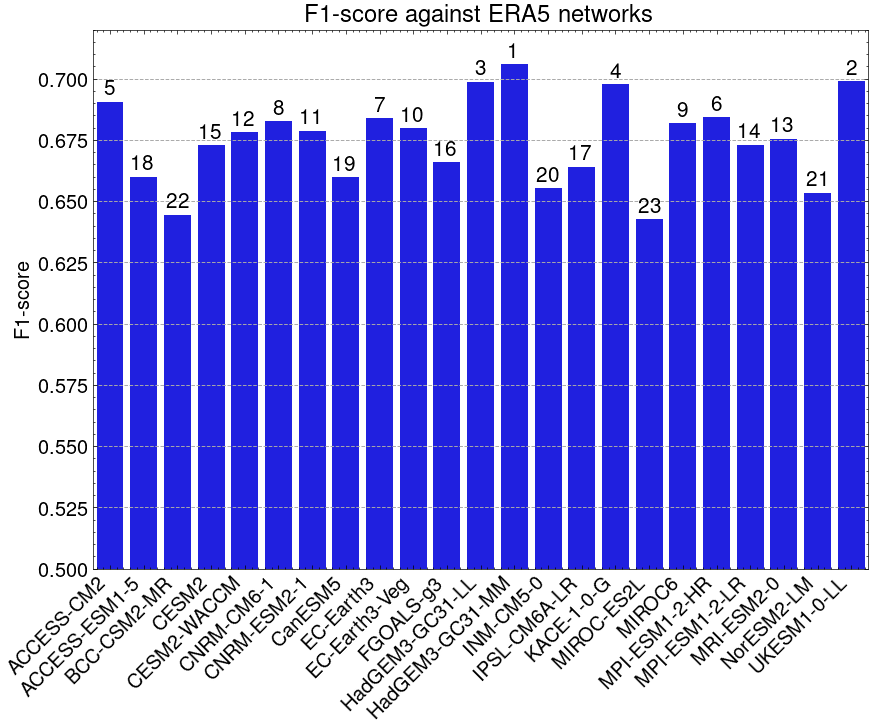

In [30]:
barplot(xr_plot_perf , ranks_df, "performance_60comps_ERA5.pdf")

In [ ]:
df_plot_perf.to_csv("./performance_60comps_ERA5.csv",index=False)
ranks_df.to_csv("./performance_60comps_ERA5_ranks.csv",index=False)

In [11]:
# Group the data and calculate the mean F1-score for each model and season
df_grouped = df_f1score_global.groupby(["model", "season"], as_index=False)["F1-score"].mean()
df_grouped = df_grouped[df_grouped.isin(to_keep_models).any(axis=1)] #select models
# Define the season groups as lists
season_groups = ["[12, 1, 2]", "[3, 4, 5]", "[6, 7, 8]", "[9, 10, 11]"]

# Create a dictionary to hold the DataFrames for each season group
df_seasons_grouped = { group: df_grouped[df_grouped["season"] == group]  for group in season_groups
}
xr_seasons_grouped = { group: xr.DataArray(data=df_seasons_grouped[group]["F1-score"].values,dims=["model"],
                            coords=dict(model=("model",df_seasons_grouped[group].model.values)),
                            attrs= {"variable_group":"F1-score","units":""},name="F1-score")  for group in season_groups
}

#Calculate rank of models for each season
df_ranks_grouped = {}
for group in season_groups:
    df_seasons_grouped[group].set_index('model', inplace=True)
    df_ranks_grouped[group] = df_seasons_grouped[group].rank(axis=0, ascending=False, method='min')
    df_ranks_grouped[group].rename(columns = {'F1-score':'Rank'}, inplace = True)

In [12]:
# Save xr_seasons_grouped (xarray DataArrays)
with open('./xr_seasons_grouped_era5.pkl', 'wb') as f:
    pickle.dump(xr_seasons_grouped, f)

# Save df_ranks_grouped
with open('./df_ranks_grouped_era5.pkl', 'wb') as f:
    pickle.dump(df_ranks_grouped, f)

In [36]:
df_f1score_perf_selected_models = df_f1score_global.groupby(["model","ensemble"],as_index=False)["F1-score"].mean()
df_f1score_perf_selected_models["model_ensemble"] = df_f1score_perf_selected_models[["model","ensemble"]].astype(str).apply('_'.join, axis=1)
df_f1score_perf_selected_models = df_f1score_perf_selected_models[df_f1score_perf_selected_models.isin(to_keep).any(axis=1)]
df_f1score_perf_selected_models = df_f1score_perf_selected_models.drop(columns=["model","ensemble"])
df_f1score_perf_selected_models = df_f1score_perf_selected_models.rename(columns = {'F1-score':'dcme'}, inplace = False).set_index(['model_ensemble'])#.to_xarray()

In [37]:
new_xr_perf =  xr.DataArray(data=df_f1score_perf_selected_models["dcme"].values,dims=["model_ensemble"],
                            coords=dict(model_ensemble=("model_ensemble",new_xr_ind.model_ensemble.data)),
                            attrs= {"variable_group":"cme","units":""},name="dcme")
new_xr_perf_ssp370 =  xr.DataArray(data=df_f1score_perf_selected_models["dcme"].values,dims=["model_ensemble"],
                            coords=dict(model_ensemble=("model_ensemble",new_xr_ind_ssp370.model_ensemble.data)),
                            attrs= {"variable_group":"cme","units":""},name="dcme")
new_xr_perf_ssp245 =  xr.DataArray(data=df_f1score_perf_selected_models["dcme"].values,dims=["model_ensemble"],
                            coords=dict(model_ensemble=("model_ensemble",new_xr_ind_ssp245.model_ensemble.data)),
                            attrs= {"variable_group":"cme","units":""},name="dcme")

In [38]:
new_xr_perf = 1.-new_xr_perf
new_xr_perf_ssp370 = 1.-new_xr_perf_ssp370
new_xr_perf_ssp245 = 1.-new_xr_perf_ssp245

In [39]:
new_xr_perf.attrs={"variable_group":"cme","units":"","obs_data":"ERA5"}
new_xr_perf_ssp370.attrs={"variable_group":"cme","units":"","obs_data":"ERA5"}
new_xr_perf_ssp245.attrs={"variable_group":"cme","units":"","obs_data":"ERA5"}

In [40]:
metric_df = new_xr_perf.to_dataframe().reset_index()
metric_df[['model','ensemble','run']] = metric_df['model_ensemble'].str.split('_',expand=True)
metric_df.groupby(["model"])["dcme"].mean().to_frame()

,dcme
model,
ACCESS-CM2,0.309666
ACCESS-ESM1-5,0.340105
BCC-CSM2-MR,0.354950
CESM2,0.321718
CESM2-WACCM,0.322454
CNRM-CM6-1,0.318751
CNRM-ESM2-1,0.318978
CanESM5,0.340314
EC-Earth3,0.321909


In [41]:
new_xr_perf.to_netcdf("./xr_perf_era5_60comps_pcmci_parcorr_timebin1_ssp585.nc")
new_xr_ind.to_netcdf("./xr_ind_era5_60comps_pcmci_parcorr_timebin1_ssp585.nc")
new_xr_perf_ssp370.to_netcdf("./xr_perf_era5_60comps_pcmci_parcorr_timebin1_ssp370.nc")
new_xr_ind_ssp370.to_netcdf("./xr_ind_era5_60comps_pcmci_parcorr_timebin1_ssp370.nc")
new_xr_perf_ssp245.to_netcdf("./xr_perf_era5_60comps_pcmci_parcorr_timebin1_ssp245.nc")
new_xr_ind_ssp245.to_netcdf("./xr_ind_era5_60comps_pcmci_parcorr_timebin1_ssp245.nc")